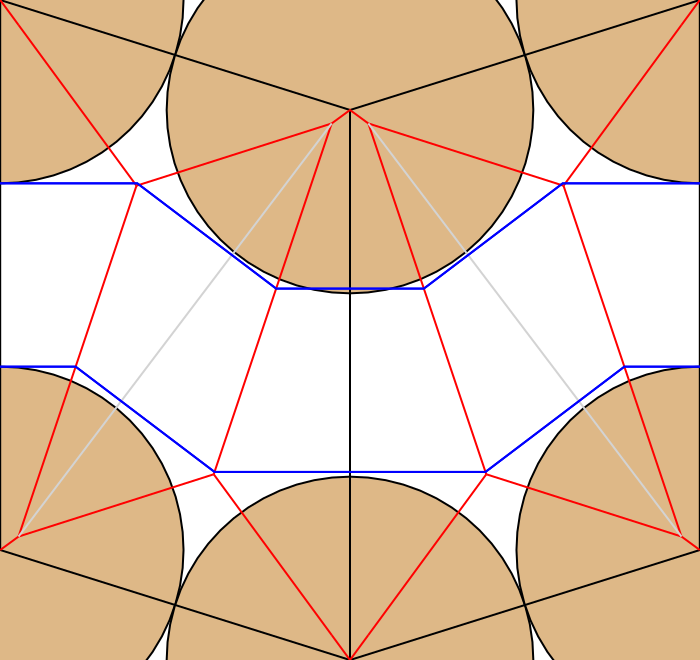

In [3]:
import networkx as nx
from itertools import count, combinations
from shapely.geometry import Polygon, Point, MultiPoint, LineString, MultiLineString
from shapely.ops import split, polygonize

from sample_trees import *
from render_pattern import *
from helper_functions import *

STEP = 10
EPSILON = 3
ROUND_PRECISION = 6

# returns true if the lang distance exceeds the tree distance
def is_split_event(c,poly,node_map,node_map_origin,d,h): 
    return lang_distances(*get_vertices(c),node_map,node_map_origin,poly,h)-tree_distance(*get_nodes(c,node_map),d)< EPSILON

# lang distance is the projection on the original polygon on both vertices and the distance between them
def lang_distances(vertex1,vertex2,node_map,node_map_origin,poly,h): 
    return project_on_origin(vertex1,poly,node_map_origin,node_map,h) + vertex1.distance(vertex2) + project_on_origin(vertex2,poly,node_map_origin,node_map,h)

# project the vertex on its edge in the original polygon
def project_on_origin(vertex,polygon,node_map_origin,node_map,h):
    
    # edge on the polygon that is connected to the vertex
    edge = [edge_from_indices(i,i+1,polygon) for i,p in enumerate(get_vertices(polygon)) if p.almost_equals(vertex,ROUND_PRECISION)]
    
    # project the vertex onto the edge mapped back to the original polygon
    d = line_in_origin(*edge,node_map_origin,node_map).project(vertex)
    
    #if there is no projection (vertex is colinear) return half the shrinking until now (if both sides are colinear = total h)
    return d if d>0 else h/2

def contract_triangle(triangle):
    
    # find the angular bisectors of the triangle
    bisectors = angular_bisectors(triangle)
    
    # find intersection point between any of the bisectors
    intersection = bisectors[0].intersection(bisectors[1])
    
    #return the angular bisectors until they intersect
    return [line_from_points(v,intersection) for v in get_vertices(triangle)]   


def shrink_polygon(polygon,sweep_length,node_map,distances,active,node_map_origin,h_last=0,creases=[],guides=[],h=0):   
    
    # shrink the polygon
    polygon_prime = polygon.buffer(-sweep_length) 
    h += sweep_length
    
    # look for contraction events
    if polygon_prime.is_empty: 
        creases += connect_points(polygon)
        return creases, guides 
    
    # look for split events, can not happen in shapes with 4 or less vertices
    if len(coords(polygon)) > 4:
        
        # find active paths (pairs of nodes)
        for nodes in query_matrix(active,1):
            
            # create a cut path between the two nodes
            cut_path = line_from_nodes(nodes[0],nodes[1],node_map)
            
            # check for split event
            if is_split_event(cut_path,polygon,node_map,node_map_origin,distances,h_last): 
                
                # add a guide line at the cut path
                guides += [cut_path]
                
                # recursively call shrink for both splits of the polygon
                [shrink_polygon(split,
                                sweep_length,
                                node_map.copy(),
                                distances,
                                get_active_paths(split,node_map, distances),
                                node_map,h,
                                creases,guides,h) for split in split(polygon, cut_path)]
                return creases,guides
    
    # contract triangles right away
    else:     
        creases += contract_triangle(polygon)
        return creases,guides

    #insert colinear vertices from polygon into polygon_prime
    polygon_prime = insert_colinear_vertices(polygon,polygon_prime)

    # generate creases, skipping the firs vertex because thats the same as the last       
    for i,p in enumerate(coords(polygon)[1:]):
        
        # p_prime if the same vertex on the prime polygon
        p_prime = coords(polygon_prime)[i+1]
        
        #extend the crease lines with a line from p to p_prime
        extend_lines(creases,line_from_points(p,p_prime))
        
        #update the node map
        node_map[p_prime] = node_map.pop(p) 

    # recursively call the shrinking with the new polygon
    return shrink_polygon(polygon_prime,
                          sweep_length,
                          node_map,
                          distances,
                          active,
                          node_map_origin,
                          h_last,
                          creases,
                          guides,h)

def insert_colinear_vertices(source,target):
    # get the coordinates of target vertices
    vertices = coords(target)
    
    # find colinear points in the source vertices
    colinear = find_colinear_points(get_vertices(source))    
    
    # copy over the colinear points from source to the target vertices
    for col_point in colinear:
        vertex = nearest_vertex(col_point,target) 
        vertices.insert(index_from_vertex(col_point,source),vertex)
        
        # if the vertex is the 0th vertex there is a copy at the end of the list which has to be removed
        if (vertices[0] == vertex): del vertices[-1]
    
    # return a modified polygon with new vertices
    return Polygon(vertices)

def get_active_paths(polygon,node_map,dist):
    # initiate a matrix of for all combinations of nodes
    paths = np.zeros((len(node_map),len(node_map)))
    
    # traverse all combinations of vertices in polygon
    for p1,p2 in combinations(get_vertices(polygon),2):
        
        # get the corresponding nodes
        node1, node2 = get_nodes(p1,node_map),get_nodes(p2,node_map)
        
        # set the path between the ndoes to 1 if the distance is bigger than epsilon, otherwise -1
        paths[node1][node2] = 1 if p1.distance(p2)-tree_distance(node1,node2,dist) > EPSILON else -1
    
    return paths

def propagate_line(line,creases,segments=[]):
    
    # find the first intersection between line and creases
    intersection_point, intersecting_crease = first_intersection(line,creases)
    
    # if no intersection point is found, stop recursive call
    if intersection_point == None: return extend_lines(segments,line)[-1] 
    
    # add a line segment until the first intersection to segments
    segments = extend_lines(segments,line_from_points(start_point(line),intersection_point))

    # recursively call the propagate function where line is mirrored through intersecting_crease
    return propagate_line(mirror_line(line,intersecting_crease,intersection_point), creases, segments)

def get_lang_polys(points,node_map,active):
    
    # add all active edges to the polys
    edges = [line_from_nodes(nodes[0],nodes[1],node_map) for nodes in query_matrix(active,-1)] 
    
    # find inactive edges
    inactive = [line_from_nodes(nodes[0],nodes[1],node_map) for nodes in query_matrix(active,1)] 
    
    #add inactive edges to polygon if they are on the outside
    edges += [line for line in inactive if is_on_polygon(line,convex_polygon(points)) and not_in_collection(line,MultiLineString(edges))] 
    
    #create polygons from the edges, if polygonize fails, just create a single conex polygon from all points
    return list(polygonize(edges)) if len(list(polygonize(edges))) >0 else [convex_polygon(points)]


def generate_rivers(polygons,tree,node_map,dist,cr,rivers=[],visited=[]):
    
    # iterate over the interior nodes of the tree
    for node in interior_nodes(tree):
        
        # traverse interior nodes until reaching a leaf
        path = path_to_leaf(node,tree)
        
        # the leaf is the last node in the path
        leaf = vertex_from_node(path[-1],node_map)
        
        # find out what polygon the leaf belongs to, pick the last entry if multiples
        polygon = vertex_in_polygon(leaf,polygons)[-1]
        
        # get the two edges on the polygon the leaf vertex is connected to
        edges = adjacent_edges(leaf,polygon)
        
        for edge in edges:
            
            # get the shortest path from start to end vertex of edge, nodes in between have to be interior nodes
            nodes_on_edge = nx.shortest_path(tree,*get_nodes(edge,node_map))
            
            # for three or less nodes there is no river
            if len(nodes_on_edge)>3: 
                
                    # create a line from the leaf node to the opposite vertex on the edge
                    e = line_from_points(leaf,end_point(edge)) if start_point(edge) == leaf else line_from_points(leaf,start_point(edge))
                    
                    # pick the interior node next to node on either left or right hand side
                    other_node = nodes_on_edge[nodes_on_edge.index(node)-1]
                    other_node = other_node if other_node in interior_nodes(tree) else nodes_on_edge[nodes_on_edge.index(node)+1]
                    
                    # check if we already created a river for this pair of nodes
                    if not ((node,other_node) in visited):
                        
                        # the width of the river is the distance between these nodes, divide by two for extrusion in both directions
                        width = dist[other_node][node]/2
                        
                        # becasue we extrude in both directions, the river starts at half the width + the weight (=size) of the leaf node 
                        start = e.interpolate(get_edge_weight(tree,path[-1]) + width)
                        
                        # move the edge dummy to the start position and rotate orthogonal to the current edge 
                        line = line_move_to(line_orthogonal(line_stretch(e,polygon.length)),start)
                        
                        # create rivers by propoagating that line through the structure
                        rivers += buffer_line_symmetric(propagate_line(line,cr),width)
                        
                        # flip the line by to propagate in the opposite direction too
                        rivers += buffer_line_symmetric(propagate_line(line_flip(line),cr),width)
                        
                        # add the combination of nodes to visited
                        visited.extend([(other_node,node),(node,other_node)])
    return rivers


# load a tree, corresponding points and a map between points and nodes
points,node_map,tree,tree_distances = lizardTree()#beetleTree()#threeNodesTree()#lizardTree()#antennaBeetleTree()

# find active paths from the points
active_paths = get_active_paths(Polygon(points),node_map,tree_distances)

# create polygons from active paths or paths on the edge of the paper
polys = get_lang_polys(points,node_map,active_paths)

# shrink the polygons to find their creases
for polygon in polys:
    active_paths = get_active_paths(polygon,node_map,tree_distances)
    crease_lines,guide_lines = shrink_polygon(polygon,STEP,node_map.copy(),tree_distances,active_paths,node_map)

# add rivers to the crease pattern
rivers = generate_rivers(polys,tree,node_map,tree_distances,crease_lines)

# place circles for visual guidance
circles = [point.buffer(get_edge_weight(tree,get_nodes(point,node_map))) for point in points]

# render the result to export.svg
render(points,circles,crease_lines,guide_lines,polys,rivers)


